# Introduction

This is a quick notebook to compare Euler's method of integration to the Leapfrog method of integration for the strings of masses and springs system. 

In [1]:
# loading some common python libraries

import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import Image
from IPython.core.display import HTML 
import sympy as sp
#from google.colab.output._publish import javascript
mathjaxurl = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
sp.init_printing(use_latex='mathjax') 
import matplotlib.patches as patches
import pandas as pd

## Class Definition

This is pretty much the same class setup as in the previous notebooks, with one change. Instead of the timestep function, I have created two functions: eulerstep and frogstep. The function eulerstep updates position and velocity based on Euler's method where:
$$a_i = A(x_i)$$
$$x_{i+1} = x_i + v_i \Delta t$$
$$v_{i+1} = v_i + a_i \Delta t$$
Here, $a_i$ is first calculated based on the positions $x_i$'s of the masses in the system. The frogstep function on the other hand updates according to the algorithm:
$$x_{i+1} = x_i + v_i \Delta t + \frac{1}{2} a_i \Delta t^2$$
$$a_{i+1} = A(x_{i+1})$$
$$v_{i+1} = v_i + \frac{1}{2}(a_i + a_{i+1}) \Delta t$$
Here we first update the position then we update the accleration, and then we use both the new acceleration and the previous one to update the velocity.

In [2]:
class object:
    def __init__(self, mass = 1, x0 = 0, v0 = 0, a0 = 0, wall = False, dt = 0.0001):
        #Establishing the parameters of an object
        self.mass = mass
        self.position = x0
        self.velocity = v0
        self.acceleration = a0
        self.energy = 0.5 * self.mass * (self.velocity)**2
        self.dt = dt
        
        #self.wall is a True-False statement as to whether the object is a wall
        self.wall = wall
        
        #self.force is a list of all of the different forces that are acting on the object
        self.forces = []
        
        #self.xhistory is all of the different positions the object has gone through; the purpose of this is for graphing
        self.xhistory = []
        
        #Keep track of initial conditions for resets
        self.xstart = x0
        self.vstart = v0
        self.astart = a0

    def eulerstep(self):
        #Processing a timestep
        self.Newton()
        self.xhistory.append(self.position)
        self.position = self.position + self.velocity * self.dt
        self.velocity = self.velocity + self.acceleration * self.dt
        self.energy = 0.5 * self.mass * (self.velocity) ** 2
    
    #We split the function frogstep into two parts so we can update the forces acting on the objects in between.
    def frogstep1(self):
        #Update the position according to the velocity and accelerations from the previous timestep
        self.xhistory.append(self.position)
        self.position = self.position + self.velocity*self.dt + 0.5*self.acceleration*self.dt**2
        
    def frogstep2(self):
        #keep track of a_i
        a_old = self.acceleration
        #update self.acceleration to be a_{i+1} based on x_{i+1}
        self.Newton()
        #update velocity according to the formula
        self.velocity = self.velocity + 0.5 * (a_old + self.acceleration) * self.dt
        self.energy = 0.5 * self.mass * (self.velocity) ** 2
        
    def force(self, Force):
        #We add a force to our list of forces
        self.forces.append(Force)

    def Newton(self):
        #Based on our list of forces, we use Newton's Second Law to find the net force and net acceleration
        Force = 0
        for F in self.forces:
            Force += F
        if self.wall == False:
            self.acceleration = Force / self.mass
        else:
            self.acceleration = 0
        self.forces = []
    
    def displace(self, x, v):
        #This is a function that displaces an object
        self.position += x
        self.velocity += v
        
    def reset(self):
        #Reset everything
        self.position = self.xstart
        self.velocity = self.vstart
        self.acceleration = self.astart
        self.energy = 0.5 * self.mass * (self.velocity)**2
        self.xhistory = []

In [3]:
class spring:
    def __init__(self, k, object1, object2, rest_length = 0, periodic = False, boundary = 0):
        #Initialize the parameters of the spring
        self.k = k
        self.obj1 = object1
        self.obj2 = object2
        self.rest = rest_length
        self.energy = 0
        
        #If the spring is the spring in the periodic boundary that loops around, self.periodic is true, and 
        #self.boundary is how much that is looped
        self.periodic = periodic
        self.boundary = boundary

    def spring_force(self):
        #Calculate the magnitude of the spring force based on the position of the attached masses and the 
        #parameters of the spring. Then add that force to the list of forces for each object
        x1 = self.obj1.position
        x2 = self.obj2.position
        if self.periodic:
            if x2 > x1:
                x2 += -self.boundary
            else:
                x2 += self.boundary
        if x2 > x1:
            deltax = (x2 - x1 - self.rest)
        else:
            deltax = (x2 - x1 + self.rest)
        f = self.k * deltax
        self.obj1.force(f)
        self.obj2.force(-f)
        self.energy = 0.5 * self.k * (deltax) ** 2

In [4]:
def damping(obj, gamma):
    #Standard damping force, but it isn't used much
    v = obj.velocity
    obj.force(-gamma*v)

In [5]:
def center(objects):
    #This transfers the system into the center of mass reference frame
    p_tot = 0
    m_tot = 0
    for obj in objects:
        m_tot += obj.mass
        p_tot += obj.mass*obj.velocity
    v_cm = p_tot/m_tot
    for obj in objects:
        obj.displace(0, -v_cm)

# Comparison

Now we are going to compare the two methods of integration according to the conditions in the cell below.

In [6]:
end_time = 1000
iters = 10000
N = 10
dt = end_time/iters
l = 1
mass = 5
k = 5
gamma = 0.1
objects = []
springs = []
wall_boundaries = True
periodic = False
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(k, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(5, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m],objects[m+1],rest_length = l))

## Euler's Method

We first do a simulation using Euler's method by displacing one of the masses and letting the system evolve.

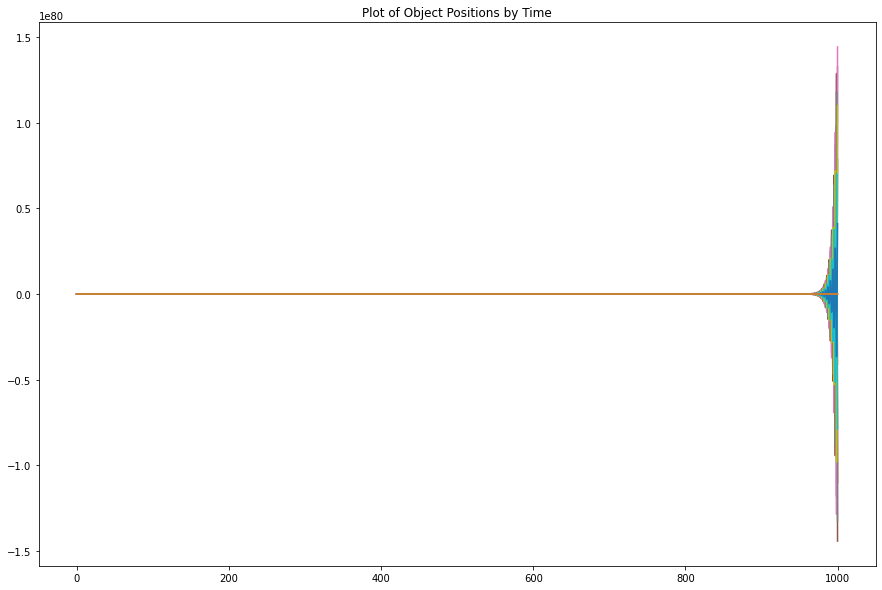

In [7]:
objects[2].displace(0, 0.3)

time = []
for i in range(iters):
    time.append(i*dt)
    for s in springs:
        s.spring_force()
    for obj in objects:
        obj.eulerstep()
plt.figure(figsize = (15,10))
plt.title("Plot of Object Positions by Time")
for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

## Leapfrog Method

Now we reset the objects and redo the simulation but this time in accordance to the Leapfrog method.

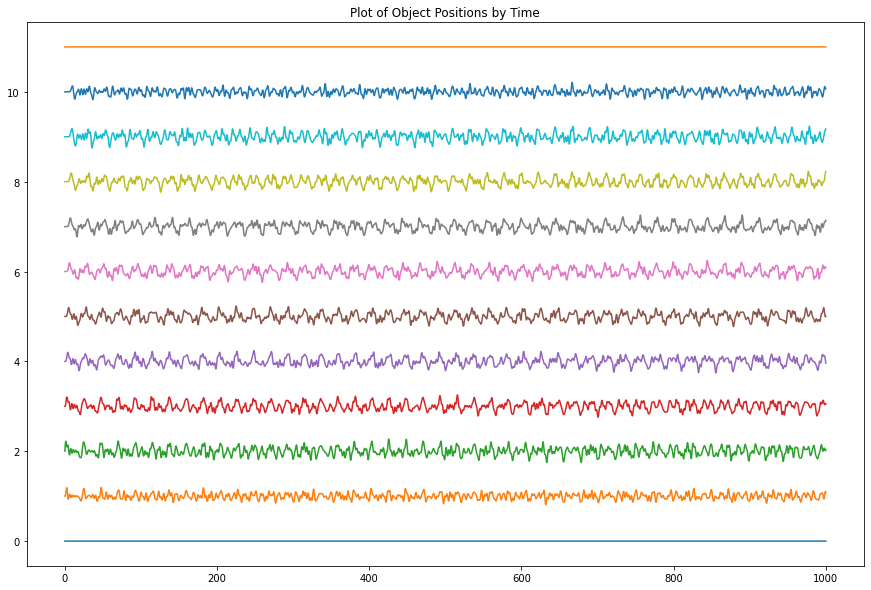

In [8]:
for obj in objects:
    obj.reset()
    
objects[2].displace(0, 0.3)

#calculate the acceleration for the first timestep, a_1
for s in springs:
    s.spring_force()
for obj in objects:
    obj.Newton()

time = []
for i in range(iters):
    time.append(i*dt)
    #update the positions from x_i -> x_{i+1}
    for obj in objects:
        obj.frogstep1()
    #update the forces in accordance to x_{i+1}
    for s in springs:
        s.spring_force()
    #update a_i -> a_{i+1} and v_i -> v_{i+1}
    for obj in objects:
        obj.frogstep2()
plt.figure(figsize = (15,10))
plt.title("Plot of Object Positions by Time")
for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()